# Week 5 - Illustrations of SABR


## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Spring 2023

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0,'../cmds')
from options import *
from volskew import *

In [2]:
#from numpy import poly1d
from scipy.optimize import fsolve
from scipy.optimize import minimize

from pandas.tseries.offsets import Day, BDay
from datetime import date

# Loading the Volatility Data

In [3]:
LOADFILE = 'vol_surfaces.xlsx'
idSHEET = -1
ISCALL = False
BETA = .5
TARG_T = .6
doSLIM = False

ticksRates = ['ED']

info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')

labels = info.columns
sheet = labels[idSHEET]

tick = info.loc['futures ticker',sheet]

ts, ivol_mkt = load_vol_surface(LOADFILE,sheet,ISCALL)

if tick in ticksRates:
    ts['Future Price'] = 100-ts['Future Price']
    ISCALL = 1-ISCALL

strikes = get_strikes_from_vol_moneyness(ISCALL,ivol_mkt,ts)

In [4]:
bdays = BDay()

t = pd.to_datetime(info.loc['option expiration',sheet]) - TARG_T * datetime.timedelta(365)
t += 1 * bdays
t = t.strftime('%Y-%m-%d')

if 'P50dVol' in ivol_mkt.columns:
    colATM = 'P50dVol'
else:
    colATM = 'C50dVol'

volATM = ivol_mkt.loc[t,colATM]
F = ts.loc[t,'Future Price']
strike_grid = strikes.loc[t]
T = ts.loc[t,'Expiration Option']

ivol_obs = ivol_mkt.loc[t]

In [5]:
summary = pd.DataFrame([tick,t,f'{T:.2f} years'],index=['ticker','date','expiration'],columns=['reference data'])
summary

,reference data
ticker,ED
date,2023-02-13
expiration,0.60 years


# Optimization

In [6]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    ivol_mod = np.zeros(len(strike_grid))
    
    for i,K in enumerate(strike_grid):
         ivol_mod[i] = sabr(BETA,nu,rho,alpha,F,K,T)
    
    error = ((ivol_mod - ivol_obs)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivol_mod = np.zeros(len(strike_grid))
    
    for i,K in enumerate(strike_grid):
         ivol_mod[i] = sabr_slim(BETA,nu,rho,F,K,T,volATM)
    
    error = ((ivol_mod - ivol_obs)**2).sum()
    
    return error

In [7]:
if not doSLIM:
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    x0 = np.array([.6,0,.1])


optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   

if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,T,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strike_grid,T,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strike_grid,T)

# Estimation

In [8]:
error = optim.fun
param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta ($\beta$),0.5000
alpha ($\alpha$),0.3672
nu ($\nu$),0.9768
rho ($\rho$),-0.2559
fit error,0.0010


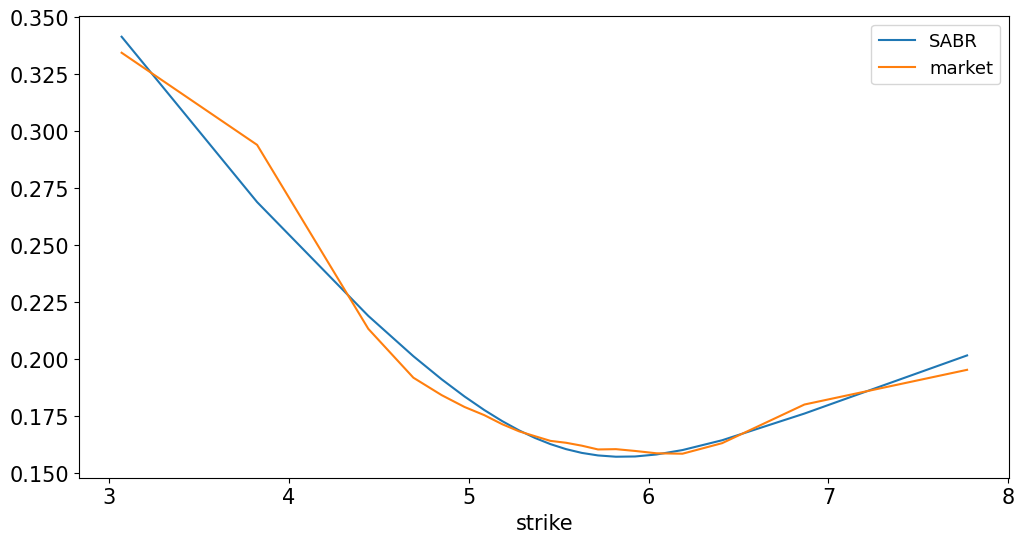

In [9]:
comp = pd.concat([ivolSABR,ivol_obs],axis=1)
comp.columns = ['SABR','market']
comp['strike'] = strike_grid
comp.set_index('strike',inplace=True)
comp.plot();

# Modeled Volatility Curves

### Calculate SABR Vol for various spots

In [10]:
Fgrid = np.arange(F*(1-volATM),F*(1+volATM),F*volATM/2)
        
volPath = pd.DataFrame(columns=ivolSABR.index,index=Fgrid)

if doSLIM:
    for f in Fgrid:
        volPath.loc[f,:] = sabr_slim(BETA,nustar,rhostar,f,strike_grid,T,volATM)
else:
    for f in Fgrid:
        volPath.loc[f,:] = sabr(BETA,nustar,rhostar,alphastar,f,strike_grid,T)

### Transform Delta to Strike

In [11]:
strikesPath = pd.DataFrame(np.repeat(strike_grid.values.reshape(-1,1),len(Fgrid),axis=1).T, index=Fgrid, columns=ivolSABR.index)

### Graph Vol Curves

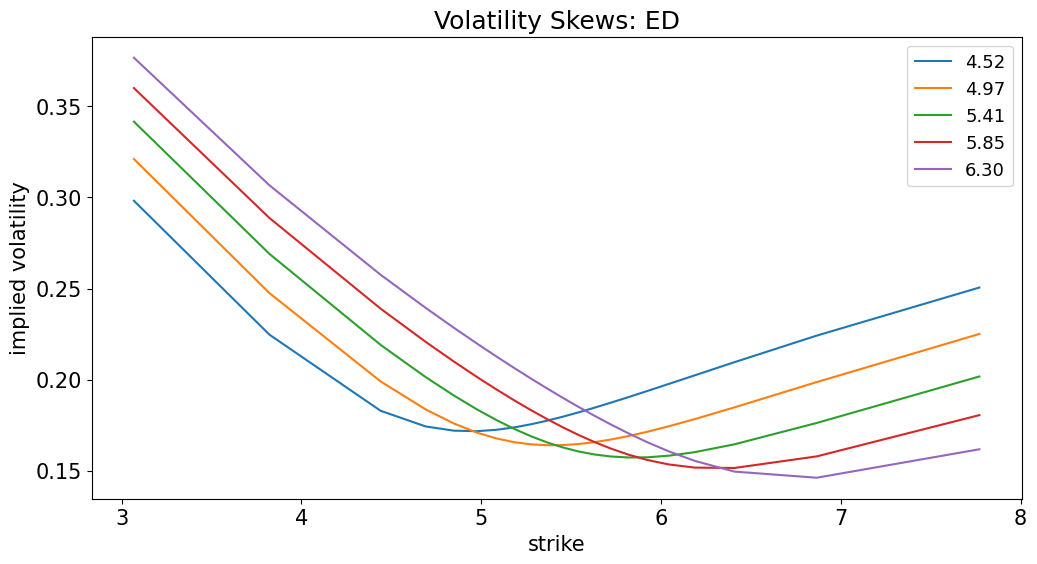

In [12]:
fig, ax = plt.subplots()

for row in volPath.index:
    plotdata = pd.concat([strikesPath.loc[row],volPath.loc[row]],axis=1)
    plotdata.columns = ['strike','vol']
    plotdata.set_index('strike',inplace=True)
    plotdata.plot(ax=ax)

plt.legend([f'{c:.2f}' for c in volPath.index]);

plt.ylabel('implied volatility')
plt.title(f'Volatility Skews: {tick}')
plt.show()

# Vol Path

In [13]:
backbone = pd.DataFrame(index=Fgrid,dtype=float,columns=['vol path'])
backbone.index.name = 'strike'
for f in Fgrid:
    backbone.loc[f] = sabrATM(BETA,nustar,rhostar,alphastar,f,f,T)
    
backbone['vol path approx'] = alphastar/(Fgrid**(1-BETA))

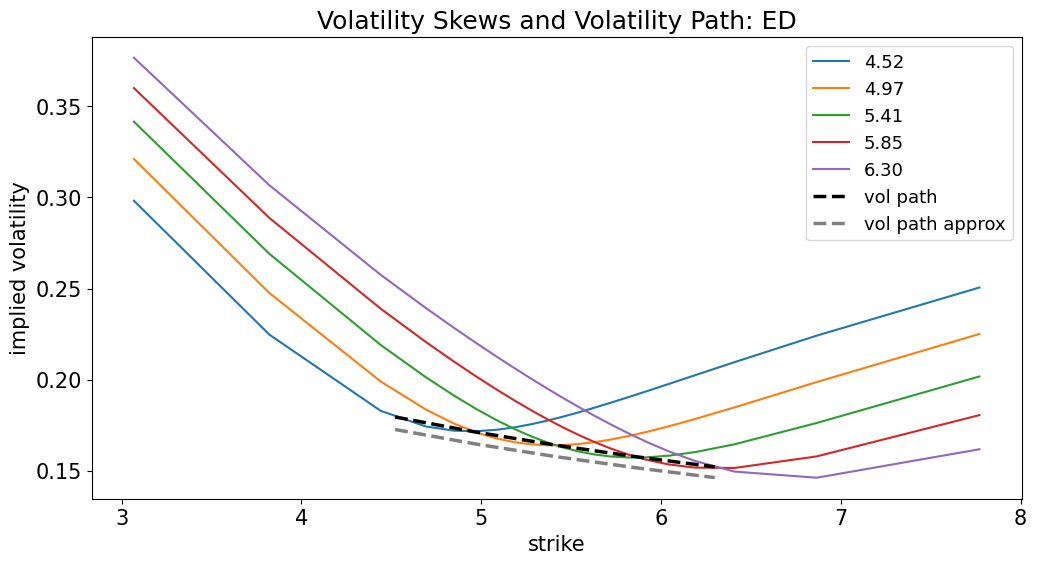

In [14]:
fig, ax = plt.subplots()

for row in volPath.index:
    plotdata = pd.concat([strikesPath.loc[row],volPath.loc[row]],axis=1)
    plotdata.columns = ['strike','vol']
    plotdata.set_index('strike',inplace=True)
    plotdata.plot(ax=ax)
    
backbone.plot(ax=ax,color=['black','gray'],linewidth=2.5,linestyle='--')

plt.legend([f'{c:.2f}' for c in volPath.index] + ['vol path','vol path approx']);
plt.ylabel('implied volatility')
plt.title(f'Volatility Skews and Volatility Path: {tick}')
plt.show()

# Other Assets

In [15]:
ISCALL = False
TARG_T = .6
betagrid = [1,.5,0]
params = dict()

/Users/markhendricks/Projects/finm-fiderivs-2023/dev/volskew.py:42: RuntimeWarning: invalid value encountered in sqrt
  return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))
/Users/markhendricks/Projects/finm-fiderivs-2023/dev/volskew.py:42: RuntimeWarning: invalid value encountered in log
  return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))


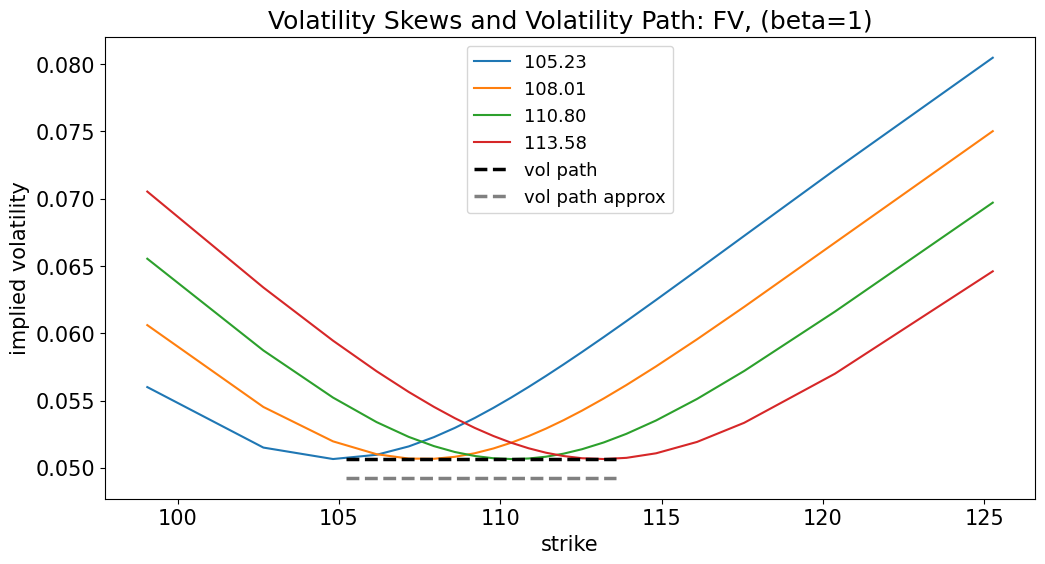

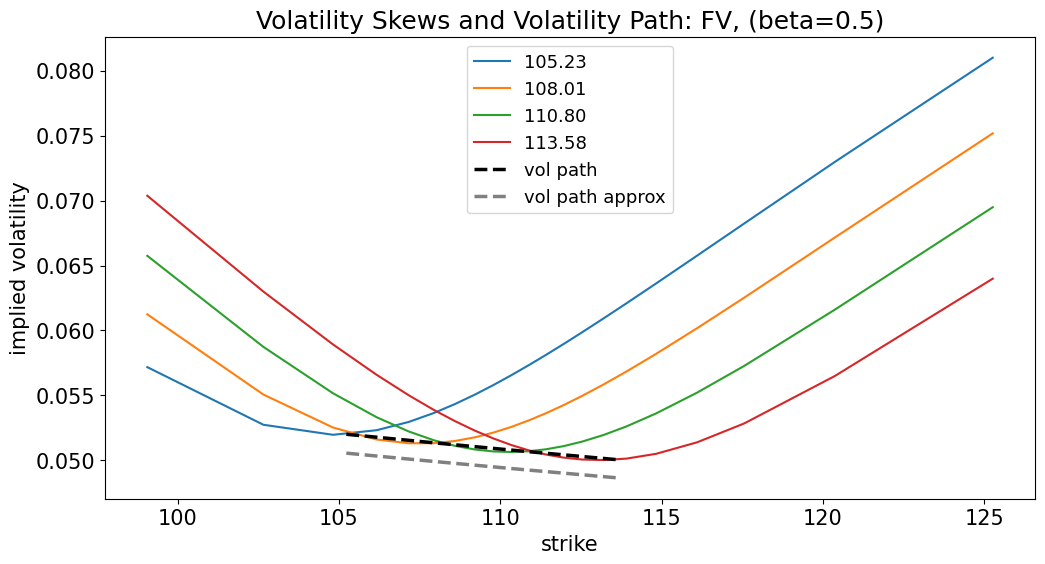

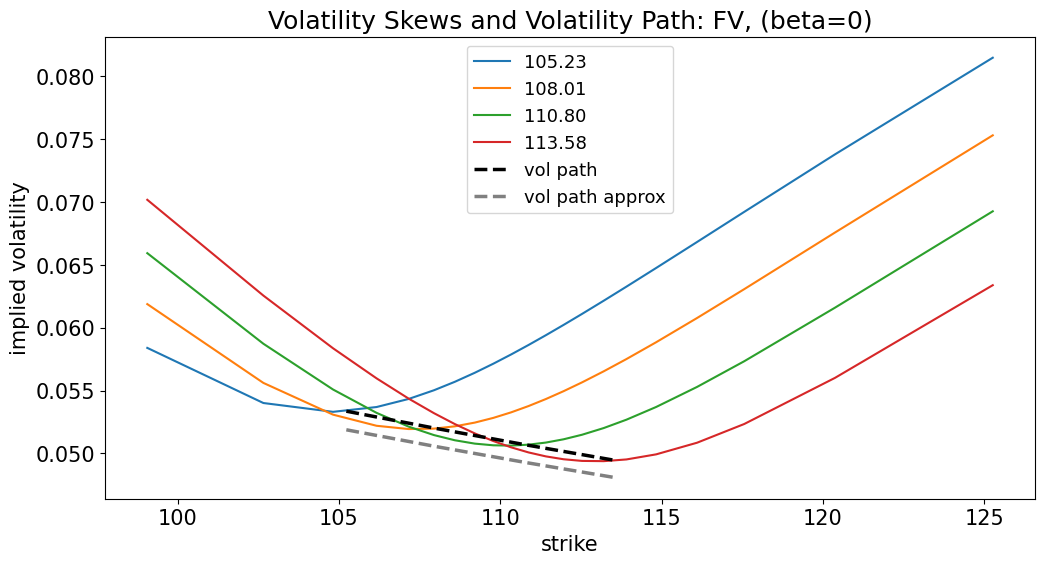

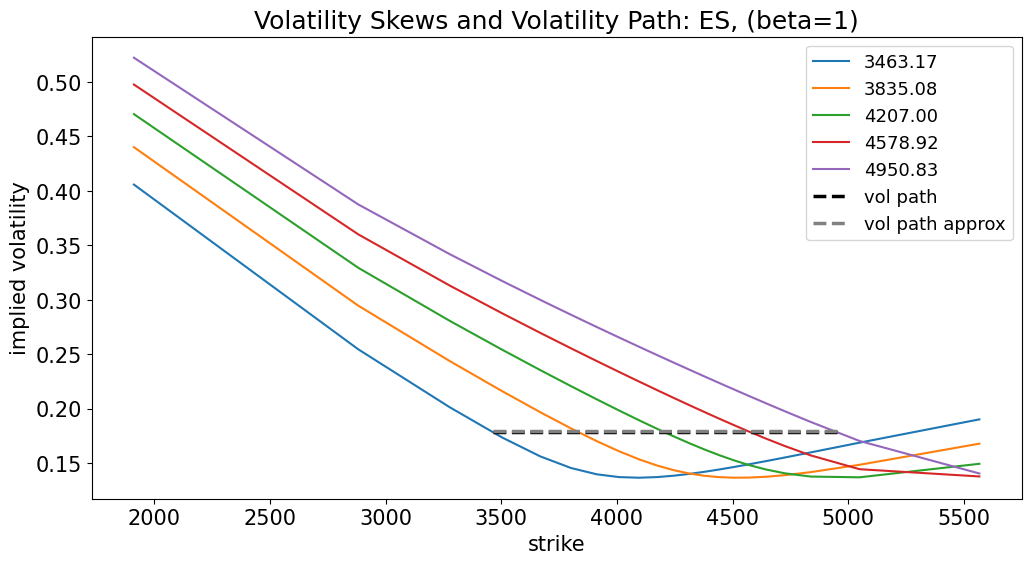

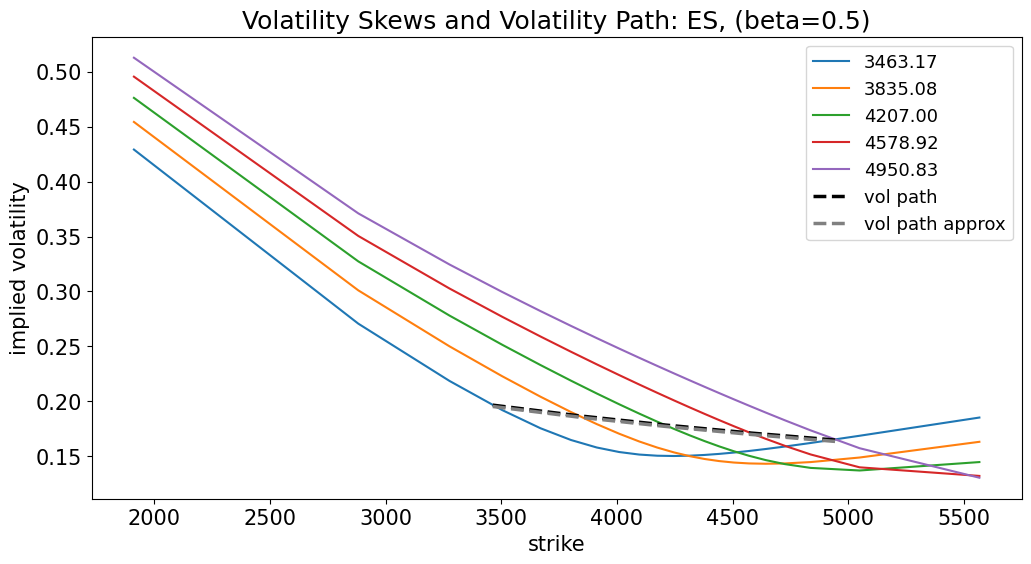

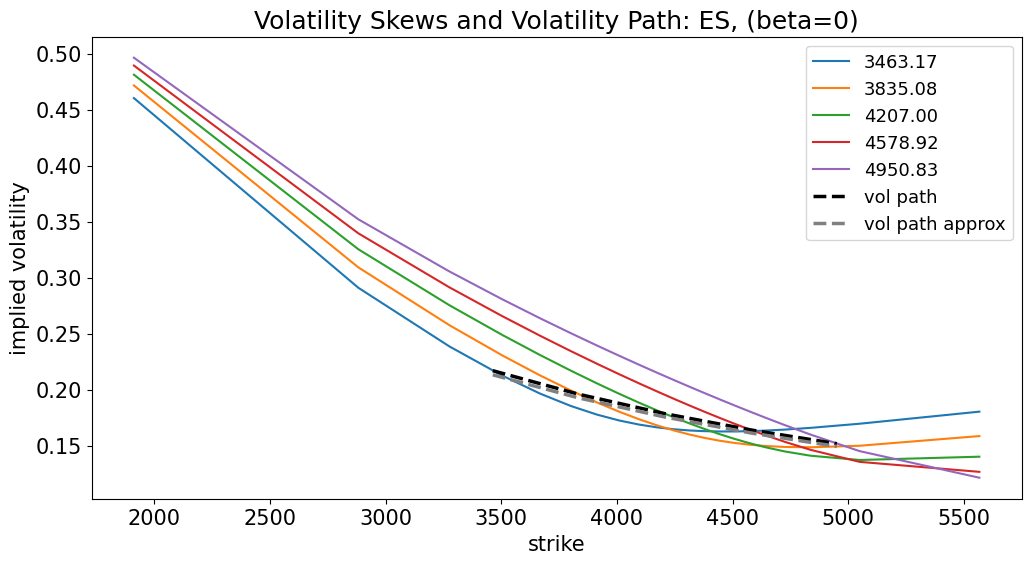

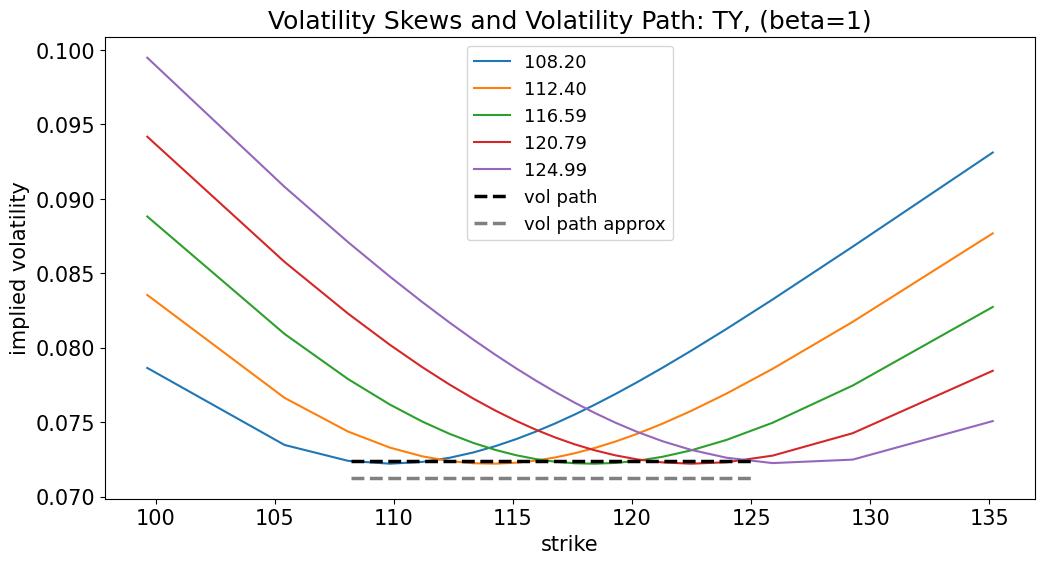

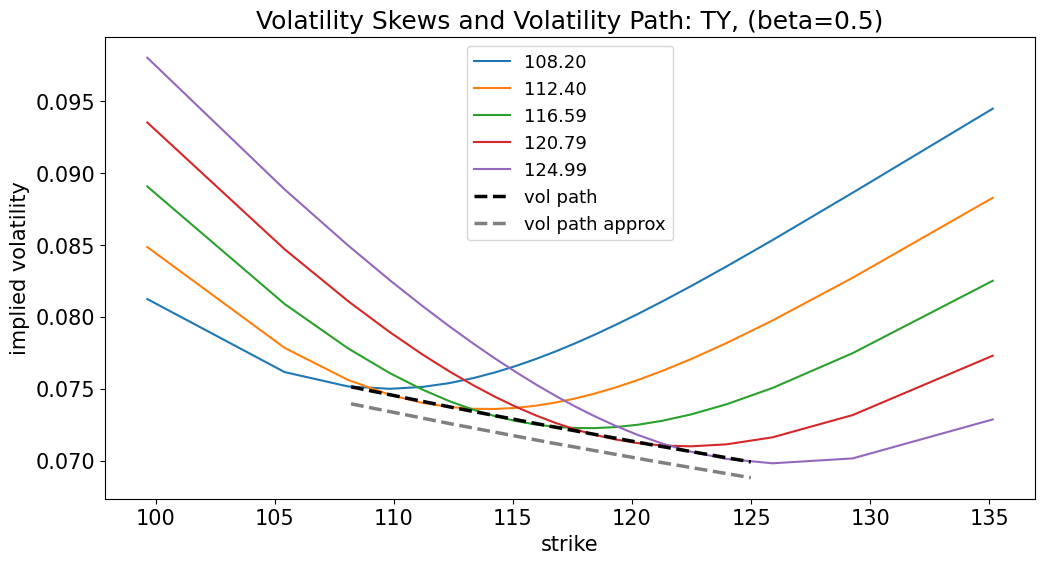

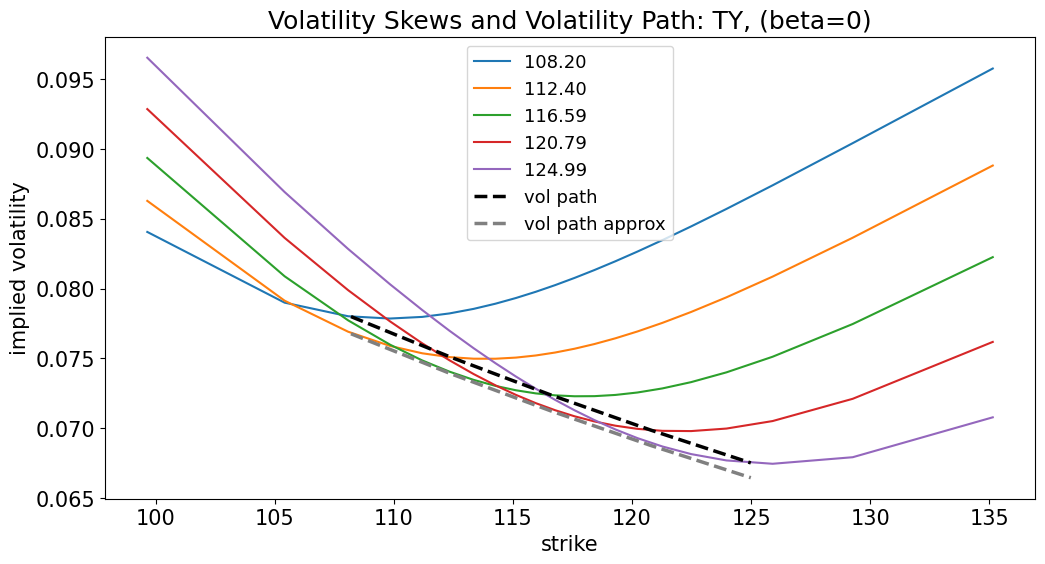

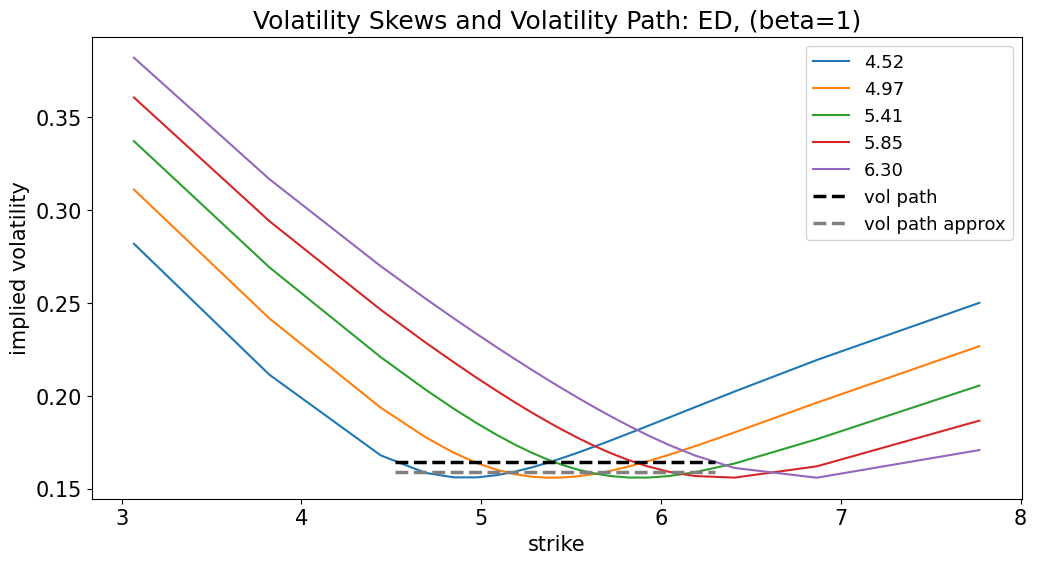

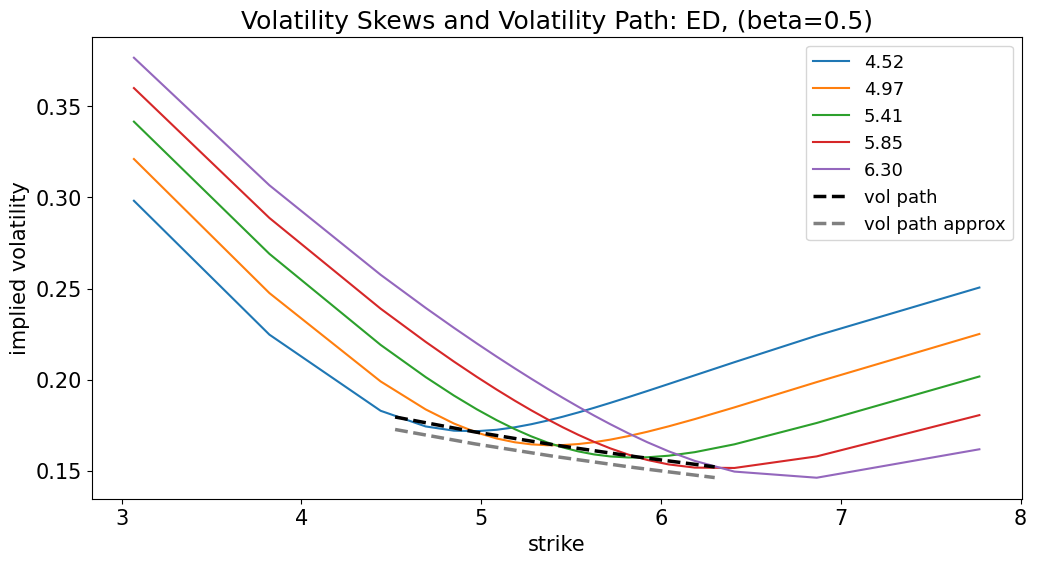

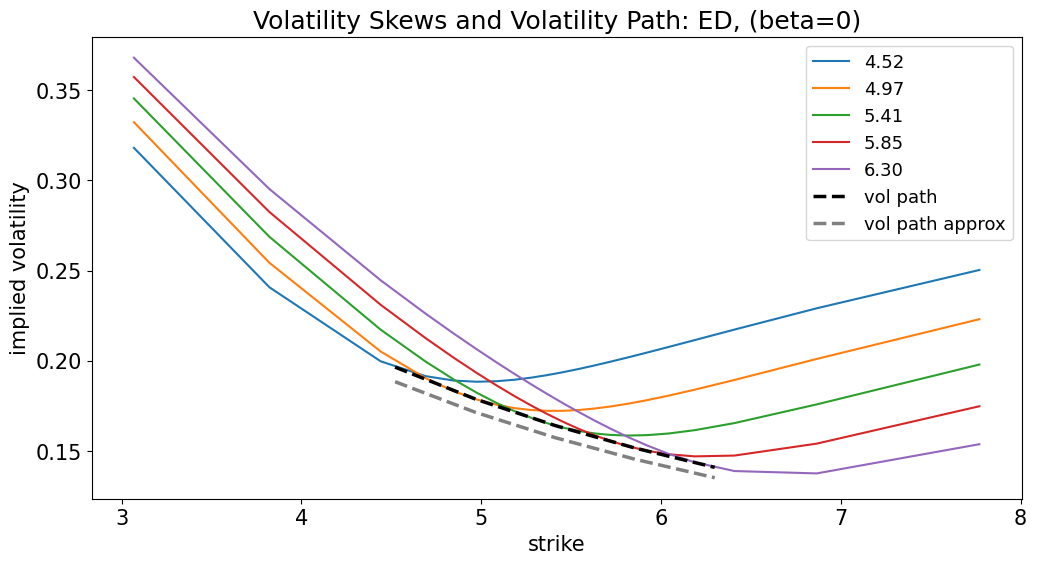

In [16]:
for i in range(info.shape[1]):
    out = list()
    for beta in betagrid:
        out.append(sabr_volpaths(LOADFILE, i, ISCALL, beta, TARG_T))        
        
    tick = out[-1]['summary'].iloc[0,0]    
    params[tick] = pd.concat([ob['params'] for ob in out],axis=1)
    params[tick].columns = betagrid
    params[tick].style.format('{:.4f}')    

In [17]:
tab = pd.concat(params,axis=1)
tab

FV                            ES             \
                       1.0       0.5       0.0       1.0        0.5   
beta ($\beta$)    1.000000  0.500000  0.000000  1.000000   0.500000   
alpha ($\alpha$)  0.049268  0.518522  5.460042  0.179880  11.492573   
nu ($\nu$)        0.757672  0.760657  0.764239  1.141714   0.995677   
rho ($\rho$)      0.038291  0.079615  0.120788 -0.721957  -0.674393   
fit error         0.000041  0.000042  0.000043  0.000219   0.000280   

                                    TY                            ED  \
                         0.0       1.0       0.5       0.0       1.0   
beta ($\beta$)      0.000000  1.000000  0.500000  0.000000  1.000000   
alpha ($\alpha$)  738.294787  0.071273  0.769214  8.306057  0.158859   
nu ($\nu$)          0.860948  0.569426  0.566438  0.566318  1.033813   
rho ($\rho$)       -0.612817 -0.078086 -0.005575  0.066459 -0.361155   
fit error           0.000537  0.000011  0.000011  0.000011  0.001138   

                                      
                       0.5       0.0  
beta ($\beta$)    0.500000  0.000000  
alpha ($\alpha$)  0.367213  0.851966  
nu ($\nu$)        0.976809  0.934137  
rho ($\rho$)     -0.255900 -0.138746  
fit error         0.000980  0.000934